Candidate: Bui Ngoc Minh Man
====

Performance Researcher Test
==========

**Question**

1. Load gateway_questions.csv from gateway_questions.zip. This contains data for orders sent to various gateways (connections to the exchange), and whether or not the orders succeeded (hit the exchange before competitors). Does the data suggest that any particular gateway or gateways are faster than others? (Please share your analysis code/notebook with us).

2. Bonus (optional, hard) question: from the data, can you determine any other factors affecting the probability of an order succeeding, other than the gateway?

3. Bonus question (only answer if you have a trading/quant background): is there anything interesting about the orders sent there?

**Answer**

The data contains 500,000 transactions within about 4 minutes in high-frequency trading concept. First, I do some data formatting, check missing values, add some features for analysis steps later.

# Question 1. 

First, we look at the distribution of following features: `price`, `quantity` to each gateway. Clearly, sent order to these gateway have very similar distribution. Below, I also show that the number of orders to each channel is quite similar. There are some differences in success rate for each channel. Combining with argument about similar distribution above, I can conclude that **some gateways having higher success rate**. Particular, top 3 gateways with highest successful rate are **1, 6, 5**.

<img src="send_price_quantity.png">

<img src="gateway_success.png">

# Question 2.

First, I create feature `duration`, which is the duration between each sequential transaction. To check other factors affecting the probability of an order succeeding, I use `succeeded` feature and look loser to `price`, `quantity` and `duration` feature.

<img src="price.png">

**For the price feature**: There are differences in distribution between `success` and `fail` attribute. As you can see in gateway **6,7,8** , there is a peak in high price order proving that higher price tend to be harder to be succeeded.

<img src="quantity.png">

In gateway **5,7,8**, succeeded orders have slightly lower quantity

<img src="duration.png">

The same pattern can be found in duration, there is some slightly differences in distribution of success and fail order.

Therefore, other features like `price`, `quantity` and `duration` between transactions can affect probability of order succeeding. I also check the `timestamp` with hypothesis that `Different time can also affect order succeeding`, but from the data, it seems wrong. The series is quite stationary over time except no-succeeded order in last 2 seconds.

<img src="timestamp.png">

# Question 3.

I am quite a newbie in financial field so I only point out some pattern without proof. 

<img src="price_pattern.png">

* Trading price has some pattern of Brownian Motion 
* `diff_price` and `diff_log_price` are noisy with high volatility
* `diff_log_price` of succeeded orders are quite a stationary time series, maybe can be model with simple AR model or ARCH/GARCH model
* Although success orders take only 1%, traders still have profit
* Conspiracy theory: There are two flows in automated system, one is to make noise to the market, other flow is to make profit.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
import seaborn as sns

In [2]:
def missing_values_table(df):
    """
    Input: A data frame
    Ouput: Amount of missing values,
         Percentage of missing values in each feature
    """
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns={
        0: 'Missing Values',
        1: '% of Total Values'
    })

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
            '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

# Load and format data

In [3]:
df = pd.read_csv('gateway_question.csv')
print(df.shape)
df['timestamp'] = df['timestamp'].replace('[^0-9]','', regex=True).astype('int64')
df['gateway_targeted'] = df['gateway_targeted'].astype('category')
df['timestamp'] = pd.to_timedelta(df['timestamp'], unit='nanoseconds')
df['duration'] = df['timestamp'].diff().apply(lambda x: x.nanoseconds)
df['log_price'] = np.log(df['price'])
df['diff_log_price'] = df['log_price'].diff()
df['total_price'] = df['price']*df['quantity']
df['is_buy'] = df['side'].apply(lambda x: -1 if x=='buy' else 1)
df['profit'] = df['is_buy']*df['price']*df['quantity']

group = df.groupby('gateway_targeted')
fail_group = df[df.succeeded == False].groupby('gateway_targeted')
success_group = df[df.succeeded == True].groupby('gateway_targeted')

(500000, 6)


In [4]:
missing_values_table(df)

Selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
duration,1,0.0
diff_log_price,1,0.0


# Question 1

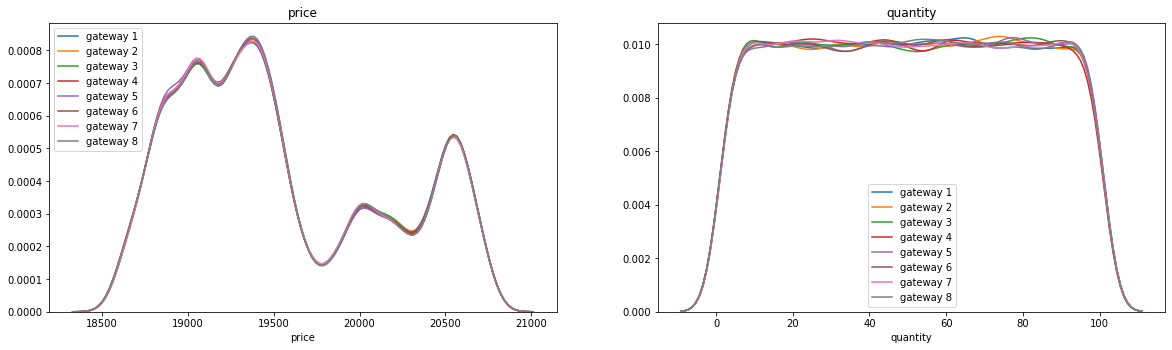

In [5]:
plt.figure(figsize=(20,50))
plt.subplot(2,1,1)
cols = ['price', 'quantity']
i=0

for col in cols:
    i+=1
    for g in group.groups:
        plt.subplot(8,2,i)
        plt.title(f'{col}')
        sns.distplot(group.get_group(g)[col], hist=False, label=f"gateway {g}")

In [6]:
table = df[['succeeded', 'gateway_targeted']].pivot_table(
    index='gateway_targeted', 
    columns='succeeded', 
    values='succeeded', 
    aggfunc=len
)
table['total'] = table[True] + table[False]
table['succeed_percent'] = table[True]*100 / (table[True] + table[False])
table

succeeded,False,True,total,succeed_percent
gateway_targeted,,,,
1,60082,2130,62212,3.423777
2,62516,125,62641,0.199550
3,61994,455,62449,0.728595
4,62640,75,62715,0.119589
5,61684,710,62394,1.137930
6,61629,1167,62796,1.858399
7,62248,29,62277,0.046566
8,62281,235,62516,0.375904


Data is recorded in about 4 minutes with 500K transactions.

# Question 2

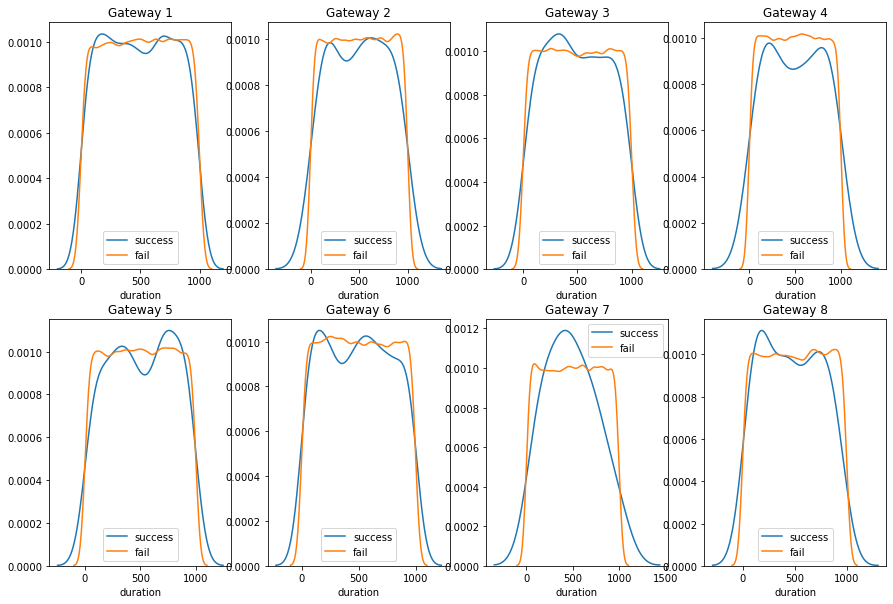

In [7]:
plt.figure(figsize=(15,10))
plt.subplot(2,4,1)
i=0
for g in group.groups:
    i+=1
    plt.subplot(2,4,i)
    plt.title(f'Gateway {g}')
    sns.distplot(success_group.get_group(g)['duration'], label='success', hist=False)
    sns.distplot(fail_group.get_group(g)['duration'], label='fail', hist=False)


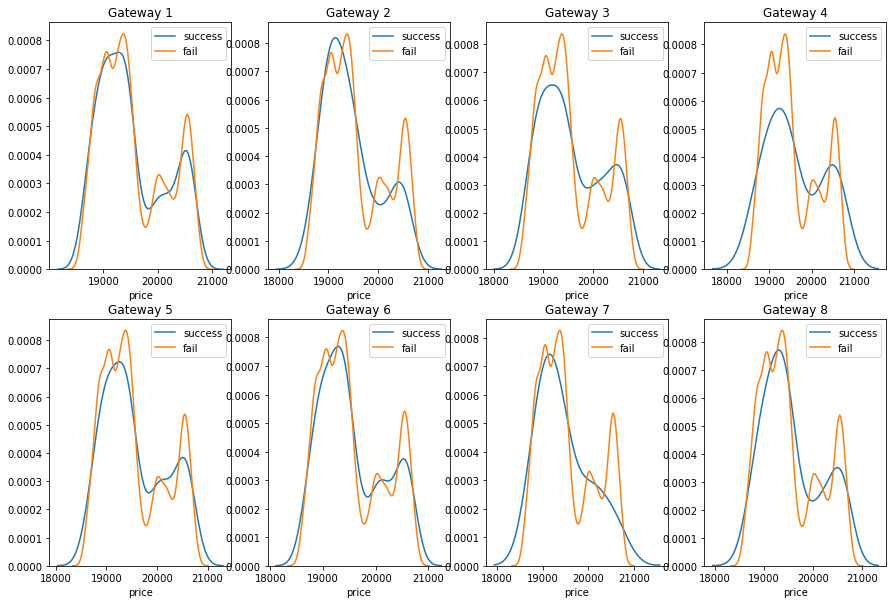

In [8]:
plt.figure(figsize=(15,10))
plt.subplot(2,4,1)
i=0
for g in group.groups:
    i+=1
    plt.subplot(2,4,i)
    plt.title(f'Gateway {g}')
    sns.distplot(success_group.get_group(g)['price'], label='success', hist=False)
    sns.distplot(fail_group.get_group(g)['price'], label='fail', hist=False)


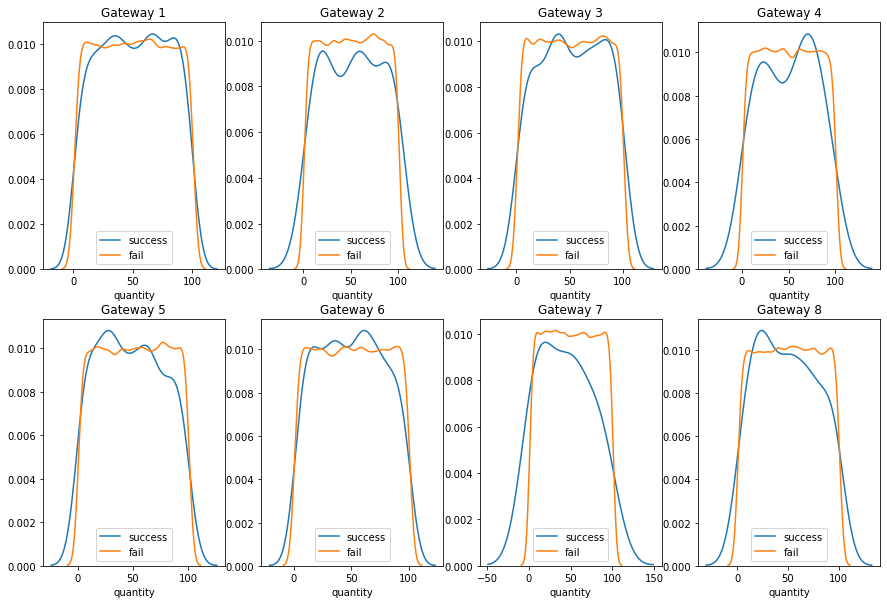

In [9]:
plt.figure(figsize=(15,10))
plt.subplot(2,4,1)
i=0
for g in group.groups:
    i+=1
    plt.subplot(2,4,i)
    plt.title(f'Gateway {g}')
    sns.distplot(success_group.get_group(g)['quantity'], label='success', hist=False)
    sns.distplot(fail_group.get_group(g)['quantity'], label='fail', hist=False)


Distribution of price and quantity in successful order to each gateway is similar. Therefore, price and quantity do not affect success rate for each gateway.

Text(0.5, 1.0, 'number of succeeded order for 2 second timestamp')

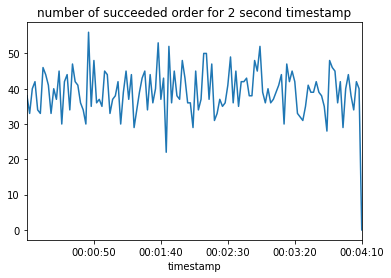

In [10]:
df.set_index('timestamp', inplace=True, drop=False)
df.resample(rule='2S')['succeeded'].sum().plot()
plt.title('number of succeeded order for 2 second timestamp')

Chuỗi thời gian biểu hiện số lượng đơn thành công trong mỗi khoảng 2s khá là dừng => có thể thời gian giao dịch không quá ảnh hưởng tốc độ chốt đơn

# Question 3

Text(0.5, 1.0, 'diff log_price of succeeded order')

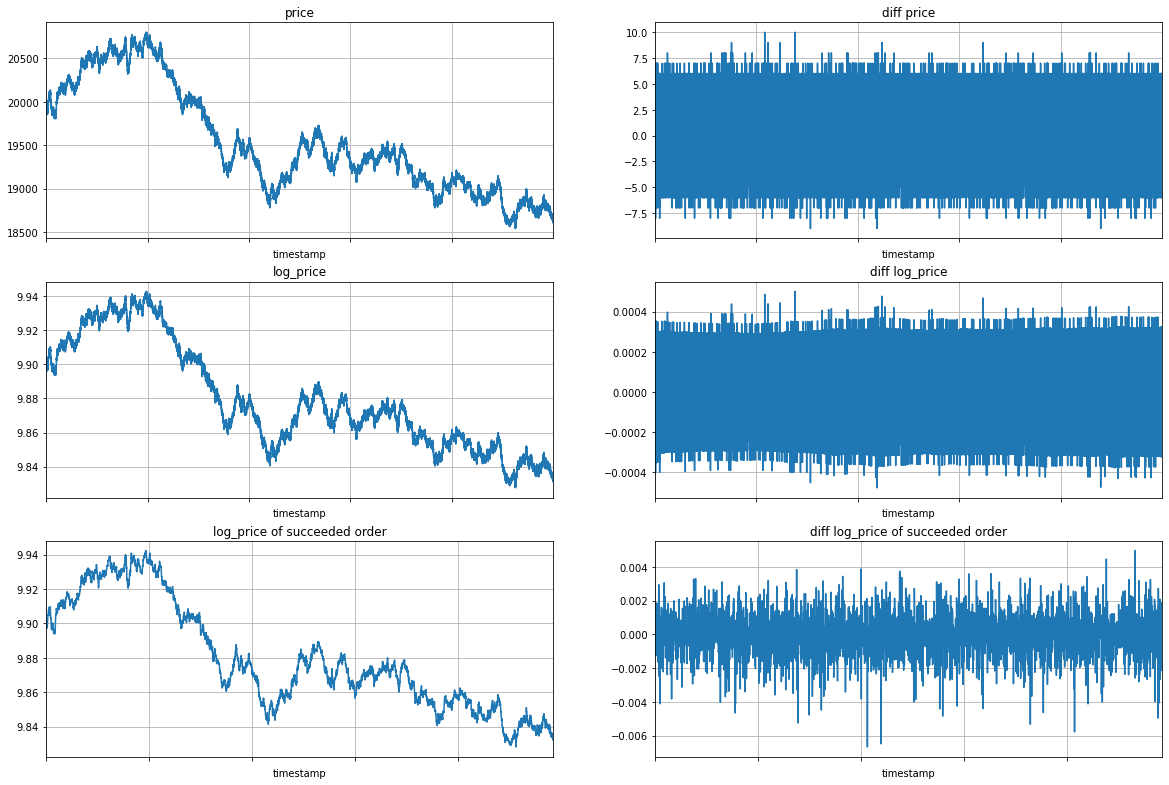

In [11]:
plt.figure(figsize=(20,15))

plt.subplot(321)
df['price'].plot()
plt.grid()
plt.title('price')

plt.subplot(322)
df['price'].diff().plot()
plt.grid()
plt.title('diff price')

plt.subplot(323)
df['log_price'].plot()
plt.grid()
plt.title('log_price')

plt.subplot(324)
df['log_price'].diff().plot()
plt.grid()
plt.title('diff log_price')

plt.subplot(325)
df[df.succeeded == True]['log_price'].plot()
plt.grid()
plt.title('log_price of succeeded order')

plt.subplot(326)
df[df.succeeded == True]['log_price'].diff().plot()
plt.grid()
plt.title('diff log_price of succeeded order')

In [12]:
df[df.succeeded == True]['profit'].sum()

113080678

In [13]:
df[df.succeeded == True]['side'].value_counts()

sell    2509
buy     2417
Name: side, dtype: int64